Reproduce results in `xi.ipynb` with `zeus21`:
1. $P(k)$
2. (Istropic) correlation function

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import zeus21
from classy import Class
from scipy.special import spherical_jn

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)

In [10]:
ClassCosmo = Class()
params = {'output': 'mPk',
          'n_s': 0.965, 
          'H0': 67.4,
          'omega_b': 0.0224,
          'omega_cdm': 0.12,
          'tau_reio': 0.054,
          'sigma8': 0.811,
          'P_k_max_1/Mpc': 10}
ClassCosmo.set(params)
ClassCosmo.compute()

In [11]:
UserParams = zeus21.User_Parameters(precisionboost=1.2)
CosmoParams_input = zeus21.Cosmo_Parameters_Input()
ClassyCosmo = zeus21.runclass(CosmoParams_input)
CosmoParams = zeus21.Cosmo_Parameters(UserParams, CosmoParams_input, ClassyCosmo) 
CorrFClass = zeus21.Correlations(UserParams, CosmoParams, ClassyCosmo)

## $P(k)$

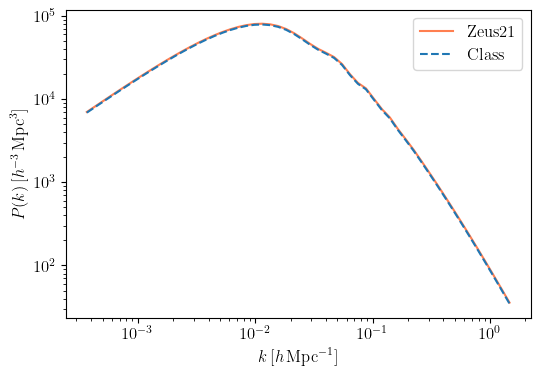

In [12]:
# Get pk from zeus21
k_zeus = CorrFClass._klistCF
pk_zeus = CorrFClass._PklinCF

# Make pk with Class
z = 0
k_min = k_zeus.min()
k_max = k_zeus.max()
k_steps = k_zeus.shape[0]
# This is supposed to be an exact reconstruction of the k array used in zeus21
k_class = np.geomspace(k_min, k_max, k_steps)
pk_class = [ClassCosmo.pk(ki, z) for ki in k_class]

plt.figure(figsize=(6, 4))
plt.plot(k_zeus, pk_zeus, label='Zeus21', c='coral')
plt.plot(k_class, pk_class, label='Class', ls='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$P(k)\,[h^{-3}\,\mathrm{Mpc}^3]$')
plt.legend()

## Correlation function (assuming isotropy)

In [13]:
a = np.linspace(0.01, 1., 1000)
Omega_m0 = 0.31
Omega_L0 = 1. - Omega_m0

def H(a):
    return np.sqrt(Omega_m0 * a**-3 + Omega_L0)

def D(a): # Linear growth factor
    integral = np.trapezoid(1 / (a**3 * (H(a))**3), a)
    D = 5 / 2 * Omega_m0 * H(a) * integral
    D_normalized = D / D[-1]
    return D_normalized

def dD_dtau(D, a):
    dD_da = np.gradient(D, a)
    return dD_da * a**2 * H(a)

dD_dtau_vals = dD_dtau(D(a), a)
D_dot = dD_dtau_vals[-1]

def integrand_v(r):
    return pk_class * spherical_jn(0, k_class*r)

def xi_v(r):
    integrand = integrand_v(r)
    return D_dot**2 / (2 * np.pi**2) * np.trapezoid(integrand, k_class)

r_list = CorrFClass.rlist_CF
xi_v = [xi_v(r) for r in r_list]
CF_v = CorrFClass.xi_RR_CF_v

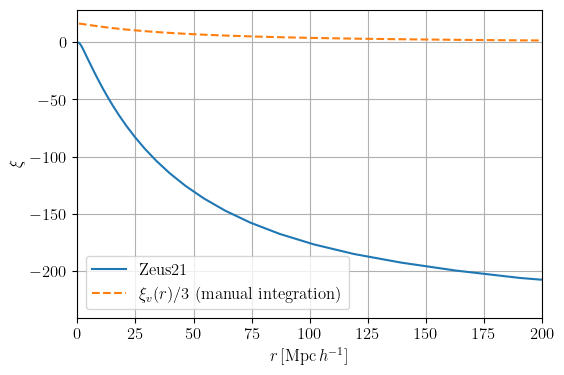

In [14]:
plt.figure(figsize=(6, 4))
plt.plot(r_list, CF_v[0, 0, :], label='Zeus21') # No smoothing
plt.plot(r_list, np.asarray(xi_v)/3, label=r'$\xi_v(r)/3$ (manual integration)', ls='--')
plt.xlim(0, 200)
plt.xlabel(r'$r\,[\mathrm{Mpc}\,h^{-1}]$')
plt.ylabel(r'$\xi$')
plt.legend()
plt.grid()

There's clearly something wrong with the Zeus curve but what is it??